<a href="https://colab.research.google.com/github/manish-anandani/Data-Science-Projects/blob/main/Network_Intrusion_Analysis_using_Pysparkv1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

Perform complex analytics on a network intrusion dataset using Pyspark

## Learning Objectives

At the end of the mini-project, we will be able to :

* analyze the data using Pyspark
* implement RDD based operations on the data
* derive insights from the complex data

### Dataset

The dataset chosen for this mini-project is a [10% subset](https://www.kdd.org/kdd-cup/view/kdd-cup-1999/Data) of the **[KDD Cup 1999 dataset](http://kdd.ics.uci.edu/databases/kddcup99/task.html)** (Computer network intrusion detection). This is the dataset used for the Third International Knowledge Discovery and Data Mining Tools Competition. The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between ``bad`` connections, called intrusions or attacks, and ``good`` normal connections. This database contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment.

## Information

Since 1999, KDD’99 has been the most widely used data set for the evaluation of anomaly detection methods. This data set is prepared by S. J. Stolfo and is built based on the data captured in DARPA’98 IDS evaluation program. DARPA’98 is about 4 gigabytes of compressed raw (binary) tcpdump data of 7 weeks of network traffic, which can be processed into about 5 million connection
records, each with about 100 bytes. KDD dataset consists of approximately 4,900,000 single connection vectors each of which contains 41 features and is labeled as either normal or an attack, with exactly one specific attack type. The simulated attacks fall into one of the following four categories:

* Denial of Service Attack (DoS): making some computing or memory resources too busy so that they deny legitimate users access to these resources.
* User to Root Attack (U2R): unauthorized access from a remote machine according to exploit machine's vulnerabilities.
* Remote to Local Attack (R2L): unauthorized access to local super user (root) privileges using system's susceptibility.
* Probing Attack: host and port scans as precursors to other attacks. An attacker scans a network to gather information or find known vulnerabilities.

KDD’99 features can be classified into three groups:

1) Basic features: this category encapsulates all the attributes that can be extracted from a TCP/IP connection. Most of these features leading to an implicit delay in detection.

2) Traffic features: this category includes features that are computed with respect to a window interval and is divided into two groups:

  * "same host" features

  * "same service" features

3) Content features: unlike most of the DoS and Probing attacks, the R2L and U2R attacks don’t have any intrusion frequent sequential patterns. This is because the DoS and Probing attacks involve many connections to some host(s) in a very short period of time, however the R2L and U2R attacks are embedded in the data portions of the packets, and normally involve only a single connection. To detect these kinds of attacks, we need some features to be able to look for suspicious behavior in the data portion, e.g., the number of failed login attempts. These features are called content features.

In [ ]:
#@title Install packages and Download Dataset
!pip -qq install pyspark
# Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/kddcup.data_10_percent.gz
# Download feature names
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/kddcup.names
print("Successfully Installed packages and downloaded datasets!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Successfully Installed packages and downloaded datasets!


### Create Spark Session and load the data

#### Import required packages

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.mllib.stat import Statistics
# from pyspark.ml.stat import Correlation

import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from operator import add

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

#### Create a Spark session

A Spark session is a combined entry point of a Spark application, which came into implementation from Spark 2.0 (Instead of having various contexts, everything is encapsulated in a Spark session)

In [ ]:
# Start spark session
# spark = SparkSession.builder.appName('LearningSpark').config('spark.ui.port', '4050').config('spark.sql.catalogImplementation','hive').enableHiveSupport().getOrCreate()
spark = SparkSession.builder.appName('MP3').config('spark.ui.port', '4050').getOrCreate()
spark

In [ ]:
# spark.sparkContext.stop()

In [ ]:
spark.sparkContext._conf.getAll()

[('spark.app.name', 'MP3'),
 ('spark.driver.host', '0c7a9fd8d191'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.port', '41325'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip &> /dev/null
!unzip ngrok-stable-linux-amd64.zip &> /dev/null

In [ ]:
!./ngrok authtoken 2bOIEyUzamnpPbik9XqjNFj7HWy_4maom5pWK1NhtBRZCnxDP

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
get_ipython().system_raw('./ngrok http 4050 &')

In [ ]:
! cat /root/.ngrok2/ngrok.yml

authtoken: 2bOIEyUzamnpPbik9XqjNFj7HWy_4maom5pWK1NhtBRZCnxDP


In [ ]:
! curl ifconfig.me

34.74.101.173

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
# !./ngrok http 4050 &

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.10/json/__init__.py", line 293, in load
    return loads(fp.read(),
  File "/usr/lib/python3.10/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.10/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.10/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


#### Creating an RDD from a File

The most common way of creating an RDD is to load it from a file. Notice that Spark's textFile can handle compressed files directly.

In [ ]:
# to access sparkContext from sparkSession instance.
sc = spark.sparkContext
print(sc.version)

3.5.0


Load the dataset and show the top 10 records

Hint: sparkContext.textFile()

In [ ]:
filePath = "/content/kddcup.data_10_percent.gz"
dataRDD = spark.sparkContext.textFile(filePath)
dataRDD.take(10)

['0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,29,29,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,39,39,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,49,49,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,59,59,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,212,1940,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2,0.00,0.00,0.00,0.00,1.00,0.00,

### RDD Basic Operations

#### Convert the data to CSV format (list of elements).

To create a Dataframe using the RDD file, convert each row into a list by splitting with a comma (,)

Hint: `map()` and `split()`

In [ ]:
data_df = spark.createDataFrame(dataRDD.map(lambda x:x.split(",")))
data_df.show(10)

+---+---+----+---+---+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+---+---+----+----+----+----+----+----+----+----+-------+
| _1| _2|  _3| _4| _5|  _6| _7| _8| _9|_10|_11|_12|_13|_14|_15|_16|_17|_18|_19|_20|_21|_22|_23|_24| _25| _26| _27| _28| _29| _30| _31|_32|_33| _34| _35| _36| _37| _38| _39| _40| _41|    _42|
+---+---+----+---+---+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+---+---+----+----+----+----+----+----+----+----+-------+
|  0|tcp|http| SF|181|5450|  0|  0|  0|  0|  0|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  8|  8|0.00|0.00|0.00|0.00|1.00|0.00|0.00|  9|  9|1.00|0.00|0.11|0.00|0.00|0.00|0.00|0.00|normal.|
|  0|tcp|http| SF|239| 486|  0|  0|  0|  0|  0|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  8|  8|0.00|0.00|0.00|0.00|1.00|0.00|0.00| 19| 19|1.00|0.00|0.05|0.00|0.00|0.00|0.00|0.00|normal.|
|  0|tcp|http| SF|235|1337|  0|  0|  0|  0|  

Count how many interactions are normal and attacked in the dataset.

Hint: apply `filter` on each row, except the rows with 'normal.', all the remaining values are attacked.

In [ ]:
data_df.printSchema()

root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: string (nullable = true)
 |-- _4: string (nullable = true)
 |-- _5: string (nullable = true)
 |-- _6: string (nullable = true)
 |-- _7: string (nullable = true)
 |-- _8: string (nullable = true)
 |-- _9: string (nullable = true)
 |-- _10: string (nullable = true)
 |-- _11: string (nullable = true)
 |-- _12: string (nullable = true)
 |-- _13: string (nullable = true)
 |-- _14: string (nullable = true)
 |-- _15: string (nullable = true)
 |-- _16: string (nullable = true)
 |-- _17: string (nullable = true)
 |-- _18: string (nullable = true)
 |-- _19: string (nullable = true)
 |-- _20: string (nullable = true)
 |-- _21: string (nullable = true)
 |-- _22: string (nullable = true)
 |-- _23: string (nullable = true)
 |-- _24: string (nullable = true)
 |-- _25: string (nullable = true)
 |-- _26: string (nullable = true)
 |-- _27: string (nullable = true)
 |-- _28: string (nullable = true)
 |-- _29: string (nullab

In [ ]:
normal = data_df.select("*").where(column('_42') == "normal.").count()
not_normal = data_df.select("*").where(column('_42') != "normal.").count()
print(normal, not_normal, normal+not_normal)

97278 396743 494021


#### Protocol and Service combinations using Cartesian product

We can compute the Cartesian product between two RDDs by using the Cartesian transformation. It returns all possible pairs of elements between two RDDs. In our case, we will use it to generate all the possible combinations between Service and Protocol in our network interactions.

First of all, isolate each collection of values in two separate RDDs. For that use `distinct` on the CSV-parsed dataset. From the dataset description, we know that protocol is the second column and service is the third.

In [ ]:
protocol_data_df = data_df.select("_2").distinct()
protocol_data_df.show()

+----+
|  _2|
+----+
| tcp|
| udp|
|icmp|
+----+



In [ ]:
service_data_df = data_df.select("_3").distinct()
service_data_df.count()
service_data_df.show()

+--------+
|      _3|
+--------+
|  telnet|
|     ftp|
|    auth|
|iso_tsap|
|  systat|
|    name|
| sql_net|
|   ntp_u|
|     X11|
|   pop_3|
|    ldap|
| discard|
|  tftp_u|
|  Z39_50|
| daytime|
|domain_u|
|   login|
|    smtp|
|     mtp|
|  domain|
+--------+
only showing top 20 rows



Now let's do the Cartesian product

Hint: [Cartesian](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.cartesian.html#:~:text=Return%20the%20Cartesian%20product%20of,and%20b%20is%20in%20other%20.)

In [ ]:
sorted(protocol_data_df.rdd.cartesian(service_data_df.rdd).collect())

[(Row(_2='icmp'), Row(_3='IRC')),
 (Row(_2='icmp'), Row(_3='X11')),
 (Row(_2='icmp'), Row(_3='Z39_50')),
 (Row(_2='icmp'), Row(_3='auth')),
 (Row(_2='icmp'), Row(_3='bgp')),
 (Row(_2='icmp'), Row(_3='courier')),
 (Row(_2='icmp'), Row(_3='csnet_ns')),
 (Row(_2='icmp'), Row(_3='ctf')),
 (Row(_2='icmp'), Row(_3='daytime')),
 (Row(_2='icmp'), Row(_3='discard')),
 (Row(_2='icmp'), Row(_3='domain')),
 (Row(_2='icmp'), Row(_3='domain_u')),
 (Row(_2='icmp'), Row(_3='echo')),
 (Row(_2='icmp'), Row(_3='eco_i')),
 (Row(_2='icmp'), Row(_3='ecr_i')),
 (Row(_2='icmp'), Row(_3='efs')),
 (Row(_2='icmp'), Row(_3='exec')),
 (Row(_2='icmp'), Row(_3='finger')),
 (Row(_2='icmp'), Row(_3='ftp')),
 (Row(_2='icmp'), Row(_3='ftp_data')),
 (Row(_2='icmp'), Row(_3='gopher')),
 (Row(_2='icmp'), Row(_3='hostnames')),
 (Row(_2='icmp'), Row(_3='http')),
 (Row(_2='icmp'), Row(_3='http_443')),
 (Row(_2='icmp'), Row(_3='imap4')),
 (Row(_2='icmp'), Row(_3='iso_tsap')),
 (Row(_2='icmp'), Row(_3='klogin')),
 (Row(_2='icmp

#### Inspecting interaction duration

select the total duration of interactions for normal and attack intrusion types.
* Use the above filtered normal and attacked data and convert the duration column to integer type using `map()`
* get the sum of duration by applying `reduce` on both the data using add operator
* find the mean of duration by dividing the sum with count

Hint: [reduce()](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.RDD.reduce.html)

In [ ]:
normal_df = data_df.select("_1").where(column('_42') == "normal.")
not_normal_df = data_df.select("_1").where(column('_42') != "normal.")
normal_df.rdd.getNumPartitions(), not_normal_df.rdd.getNumPartitions()

(1, 1)

In [ ]:
##### Summation using dataframe is also possible [normal_df.agg(sum("_1")).collect()]
mapped_rdd = normal_df.rdd.map(lambda x : int(x._1))
print(mapped_rdd.reduce(add))
stats = mapped_rdd.stats()
print(stats.mean())

21075991
216.6573223133693


In [ ]:
mapped_rdd = not_normal_df.rdd.map(lambda x : int(x._1))
print(mapped_rdd.reduce(add))
stats = mapped_rdd.stats()
print(stats.mean())

2626792
6.620890601724734


#### Data aggregation with key/value pair RDDs

We can use all the transformations and actions available for normal RDDs with key/value pair RDDs. We just need to make the functions work with pair elements.

* create a key/value pair of intrusion type and duration
* calculate the total duration of each intrusion type using `reduceByKey()`

In [ ]:
data_df.select("*").where(column('_42') != "normal.").groupby("_42").agg(sum("_1")).show(22)

+----------------+---------+
|             _42|  sum(_1)|
+----------------+---------+
|    warezmaster.|    301.0|
|          smurf.|      0.0|
|            pod.|      0.0|
|           imap.|     72.0|
|           nmap.|      0.0|
|   guess_passwd.|    144.0|
|        ipsweep.|     43.0|
|      portsweep.|1991911.0|
|          satan.|     64.0|
|           land.|      0.0|
|     loadmodule.|    326.0|
|      ftp_write.|    259.0|
|buffer_overflow.|   2751.0|
|        rootkit.|   1008.0|
|    warezclient.| 627563.0|
|       teardrop.|      0.0|
|           perl.|    124.0|
|            phf.|     18.0|
|       multihop.|   1288.0|
|        neptune.|      0.0|
|           back.|    284.0|
|            spy.|    636.0|
+----------------+---------+



In [ ]:
norm_rdd = data_df.select("*").where(column('_42') != "normal.").rdd
pair_rdd = norm_rdd.map(lambda x: (x._42, int(x._1)))

In [ ]:
pair_rdd.take(10)
pair_rdd.reduceByKey(lambda x,y : x+y).collect()

[('buffer_overflow.', 2751),
 ('loadmodule.', 326),
 ('perl.', 124),
 ('neptune.', 0),
 ('smurf.', 0),
 ('guess_passwd.', 144),
 ('pod.', 0),
 ('teardrop.', 0),
 ('portsweep.', 1991911),
 ('ipsweep.', 43),
 ('land.', 0),
 ('ftp_write.', 259),
 ('back.', 284),
 ('imap.', 72),
 ('satan.', 64),
 ('phf.', 18),
 ('nmap.', 0),
 ('multihop.', 1288),
 ('warezmaster.', 301),
 ('warezclient.', 627563),
 ('spy.', 636),
 ('rootkit.', 1008)]

### Create a DataFrame with the header as features

* Read the features (*kddcup.names*) and preprocess.

    Hints:
    - Each feature description appears row-wise in *kddcup.names*
    - The first row consists of distinct values of intrusion_types
    - Add or move the *intrusion_types* column name to the last, to align with the data.
    - Each feature is represented as *feature_name*: *type*, remove *type* after colon (:)

In [ ]:
filePath = "/content/kddcup.names"
headersRDD = spark.sparkContext.textFile(filePath)

# Add indexes to each RDD element
index_RDD = headersRDD.zipWithIndex()

# Extract the first element
first_line = index_RDD.filter(lambda x : (x[1] == 0)).map(lambda x : x[0]).take(1)
print(first_line)

# Filter the RDD and remove the first element
headers_RDD = index_RDD.filter(lambda x : (x[1] != 0))

# Remove the data type labels from feature names and add intrution type at the end of the list
headers_RDD = headers_RDD.map(lambda x : x[0].split(":")[0])
header_list = headers_RDD.take(42)
header_list.append('intrusion_type')

headers_RDD = sc.parallelize(header_list)
headers_RDD.take(42)

['back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,nmap,normal,perl,phf,pod,portsweep,rootkit,satan,smurf,spy,teardrop,warezclient,warezmaster.']


['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'intrusion_type']

* Create a dataframe with the data and headers as preprocessed feature names

In [ ]:
old_columns = data_df.columns
new_columns = headers_RDD.take(42)
for old_col, new_col in zip(old_columns, new_columns):
    data_df = data_df.withColumnRenamed(old_col, new_col)



In [ ]:
data_df.show(10)

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+--------------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|

#### What is the count of each protocol type?

Hint: apply `groupby` on protocol_type and count the records

In [ ]:
data_df.groupby(column('protocol_type')).count().show()

+-------------+------+
|protocol_type| count|
+-------------+------+
|          tcp|190065|
|          udp| 20354|
|         icmp|283602|
+-------------+------+



#### Register the DataFrame as a temporary table and extract the data using queries

Hint: [registerTempTable](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrame.registerTempTable.html)

In [ ]:
data_df.createOrReplaceTempView("Temp_Table1")

* query to extract the label and their frequencies

 Hint: `SQLContext.sql(query)`

In [ ]:
spark.sql("SELECT intrusion_type, COUNT(*) AS frequency FROM Temp_Table1 GROUP BY intrusion_type ORDER BY frequency DESC").show(25)

+----------------+---------+
|  intrusion_type|frequency|
+----------------+---------+
|          smurf.|   280790|
|        neptune.|   107201|
|         normal.|    97278|
|           back.|     2203|
|          satan.|     1589|
|        ipsweep.|     1247|
|      portsweep.|     1040|
|    warezclient.|     1020|
|       teardrop.|      979|
|            pod.|      264|
|           nmap.|      231|
|   guess_passwd.|       53|
|buffer_overflow.|       30|
|           land.|       21|
|    warezmaster.|       20|
|           imap.|       12|
|        rootkit.|       10|
|     loadmodule.|        9|
|      ftp_write.|        8|
|       multihop.|        7|
|            phf.|        4|
|           perl.|        3|
|            spy.|        2|
+----------------+---------+



* select the distinct protocol types with their count of transactions which are not normal

In [ ]:
spark.sql(" \
SELECT protocol_type, COUNT(*) AS non_normal_count \
FROM Temp_Table1 \
WHERE intrusion_type != 'normal.' \
GROUP BY protocol_type \
ORDER BY non_normal_count DESC").show(25)

+-------------+----------------+
|protocol_type|non_normal_count|
+-------------+----------------+
|         icmp|          282314|
|          tcp|          113252|
|          udp|            1177|
+-------------+----------------+



* select count of transactions in each protocol type that lasts more than 1 second (duration > 1000), with no data transfer from destination (dst_bytes == 0)

In [ ]:
spark.sql(" \
SELECT protocol_type, COUNT(*) AS non_normal_count \
FROM Temp_Table1 \
WHERE (duration > 1000 \
AND dst_bytes == 0) \
GROUP BY protocol_type \
ORDER BY non_normal_count DESC").show(25)

+-------------+----------------+
|protocol_type|non_normal_count|
+-------------+----------------+
|          tcp|             139|
+-------------+----------------+



In [ ]:
## Validate the above using another binding
data_df.where(column('duration') > 1000).where(column('dst_bytes') == 0).groupby(column('protocol_type')).count().show()

+-------------+-----+
|protocol_type|count|
+-------------+-----+
|          tcp|  139|
+-------------+-----+



In [ ]:
data_df.printSchema()

root
 |-- duration: string (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: string (nullable = true)
 |-- dst_bytes: string (nullable = true)
 |-- land: string (nullable = true)
 |-- wrong_fragment: string (nullable = true)
 |-- urgent: string (nullable = true)
 |-- hot: string (nullable = true)
 |-- num_failed_logins: string (nullable = true)
 |-- logged_in: string (nullable = true)
 |-- num_compromised: string (nullable = true)
 |-- root_shell: string (nullable = true)
 |-- su_attempted: string (nullable = true)
 |-- num_root: string (nullable = true)
 |-- num_file_creations: string (nullable = true)
 |-- num_shells: string (nullable = true)
 |-- num_access_files: string (nullable = true)
 |-- num_outbound_cmds: string (nullable = true)
 |-- is_host_login: string (nullable = true)
 |-- is_guest_login: string (nullable = true)
 |-- count: string (nullable = true)
 |-- srv_count: st

### Find the highly correlated columns

* identify the columns which are not integer type and remove those columns
* apply correlation function on the data (Hint: `Statistics.corr()`)
* collect the names of the columns on which correlation is applied
* create a dataframe with correlation matrix with index and columns as names
* get the highly correlated features by considering a correlation value greater than 0.8

    Hint: `np.triu()` , `pd.mask()`

In [ ]:
index_RDD.take(5)

[('back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,nmap,normal,perl,phf,pod,portsweep,rootkit,satan,smurf,spy,teardrop,warezclient,warezmaster.',
  0),
 ('duration: continuous.', 1),
 ('protocol_type: symbolic.', 2),
 ('service: symbolic.', 3),
 ('flag: symbolic.', 4)]

In [ ]:
from pyspark.ml.linalg import Vectors

headers_RDD = index_RDD.filter(lambda x : (x[1] != 0))
num_columns = headers_RDD.filter(lambda x : (x[0].split(':')[1]) == ' continuous.').map(lambda x : x[0].split(':')[0]).take(50)
num_df = data_df.select(num_columns)


In [ ]:
num_columns

['duration',
 'src_bytes',
 'dst_bytes',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate']

In [ ]:
for i in range(len(num_columns)):
    num_df = num_df.withColumn(num_columns[i], col(num_columns[i]).cast("float"))

In [ ]:
num_df.printSchema()

root
 |-- duration: float (nullable = true)
 |-- src_bytes: float (nullable = true)
 |-- dst_bytes: float (nullable = true)
 |-- wrong_fragment: float (nullable = true)
 |-- urgent: float (nullable = true)
 |-- hot: float (nullable = true)
 |-- num_failed_logins: float (nullable = true)
 |-- num_compromised: float (nullable = true)
 |-- root_shell: float (nullable = true)
 |-- su_attempted: float (nullable = true)
 |-- num_root: float (nullable = true)
 |-- num_file_creations: float (nullable = true)
 |-- num_shells: float (nullable = true)
 |-- num_access_files: float (nullable = true)
 |-- num_outbound_cmds: float (nullable = true)
 |-- count: float (nullable = true)
 |-- srv_count: float (nullable = true)
 |-- serror_rate: float (nullable = true)
 |-- srv_serror_rate: float (nullable = true)
 |-- rerror_rate: float (nullable = true)
 |-- srv_rerror_rate: float (nullable = true)
 |-- same_srv_rate: float (nullable = true)
 |-- diff_srv_rate: float (nullable = true)
 |-- srv_diff_host

In [ ]:
len(num_columns)

34

In [ ]:
# num_df.stat.corr(num_columns[1],num_columns[2])

In [ ]:
# num_df.rdd.take(1)
def extract_row(row):
    data=[]
    for ele in row:
        data.append(ele)
    return data

headerless_rdd = num_df.rdd.map(extract_row).collect()

In [ ]:
len(headerless_rdd), len(headerless_rdd[0])

(494021, 34)

In [ ]:

vector_set=[]
vector_list=[]
for i in range(len(headerless_rdd)):
    vector_set=[]
    for j in range(len(headerless_rdd[0])):
        vector_set.append(headerless_rdd[i][j])
    vector = Vectors.dense(vector_set)
    vector_list.append(vector.toArray())

In [ ]:
len(vector_list[0])

34

In [ ]:
data_rdd = sc.parallelize(vector_list)

In [ ]:
data_rdd.take(2)

[array([0.00000000e+00, 1.81000000e+02, 5.45000000e+03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.00000000e+00,
        8.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        9.00000000e+00, 9.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.09999999e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]),
 array([0.00000000e+00, 2.39000000e+02, 4.86000000e+02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.00000000e+00,
        8.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00

In [ ]:

pearsonCorr = Statistics.corr(data_rdd)
print(str(pearsonCorr).replace('nan', 'NaN'))


[[ 1.00000000e+00  4.25823042e-03  5.43953448e-03 ... -3.06123538e-02
   6.73916315e-03  1.04646380e-02]
 [ 4.25823042e-03  1.00000000e+00 -1.59677091e-06 ...  1.12209503e-03
  -3.92691416e-04  1.32835779e-03]
 [ 5.43953448e-03 -1.59677091e-06  1.00000000e+00 ... -1.12349013e-02
  -4.99962245e-03 -5.47081589e-03]
 ...
 [-3.06123538e-02  1.12209503e-03 -1.12349013e-02 ...  1.00000000e+00
  -1.13184441e-01 -1.15320421e-01]
 [ 6.73916315e-03 -3.92691416e-04 -4.99962245e-03 ... -1.13184441e-01
   1.00000000e+00  9.84803837e-01]
 [ 1.04646380e-02  1.32835779e-03 -5.47081589e-03 ... -1.15320421e-01
   9.84803837e-01  1.00000000e+00]]


In [ ]:
# eliminating names of columns having string type
pearsonCorr.shape

(34, 34)

In [ ]:
#  fill the null values with 0
filled_arr = np.nan_to_num(pearsonCorr, nan=0)
filled_arr

array([[ 1.00000000e+00,  4.25823042e-03,  5.43953448e-03, ...,
        -3.06123538e-02,  6.73916315e-03,  1.04646380e-02],
       [ 4.25823042e-03,  1.00000000e+00, -1.59677091e-06, ...,
         1.12209503e-03, -3.92691416e-04,  1.32835779e-03],
       [ 5.43953448e-03, -1.59677091e-06,  1.00000000e+00, ...,
        -1.12349013e-02, -4.99962245e-03, -5.47081589e-03],
       ...,
       [-3.06123538e-02,  1.12209503e-03, -1.12349013e-02, ...,
         1.00000000e+00, -1.13184441e-01, -1.15320421e-01],
       [ 6.73916315e-03, -3.92691416e-04, -4.99962245e-03, ...,
        -1.13184441e-01,  1.00000000e+00,  9.84803837e-01],
       [ 1.04646380e-02,  1.32835779e-03, -5.47081589e-03, ...,
        -1.15320421e-01,  9.84803837e-01,  1.00000000e+00]])

In [ ]:
# creating a dataframe with correlation matrix
index_values = num_columns
column_values = num_columns
corr_df = pd.DataFrame(data = filled_arr, index = index_values, columns = column_values)
corr_df = corr_df.round(1)
corr_df.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
duration,1.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.1,0.0,0.1,...,0.0,-0.1,-0.1,0.4,0.0,-0.0,-0.0,-0.0,0.0,0.0
src_bytes,0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0
dst_bytes,0.0,-0.0,1.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.1,...,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
wrong_fragment,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.1,-0.1,0.1,-0.0,0.0,-0.0,-0.0,0.0,-0.0
urgent,0.0,-0.0,0.0,-0.0,1.0,0.0,0.1,0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


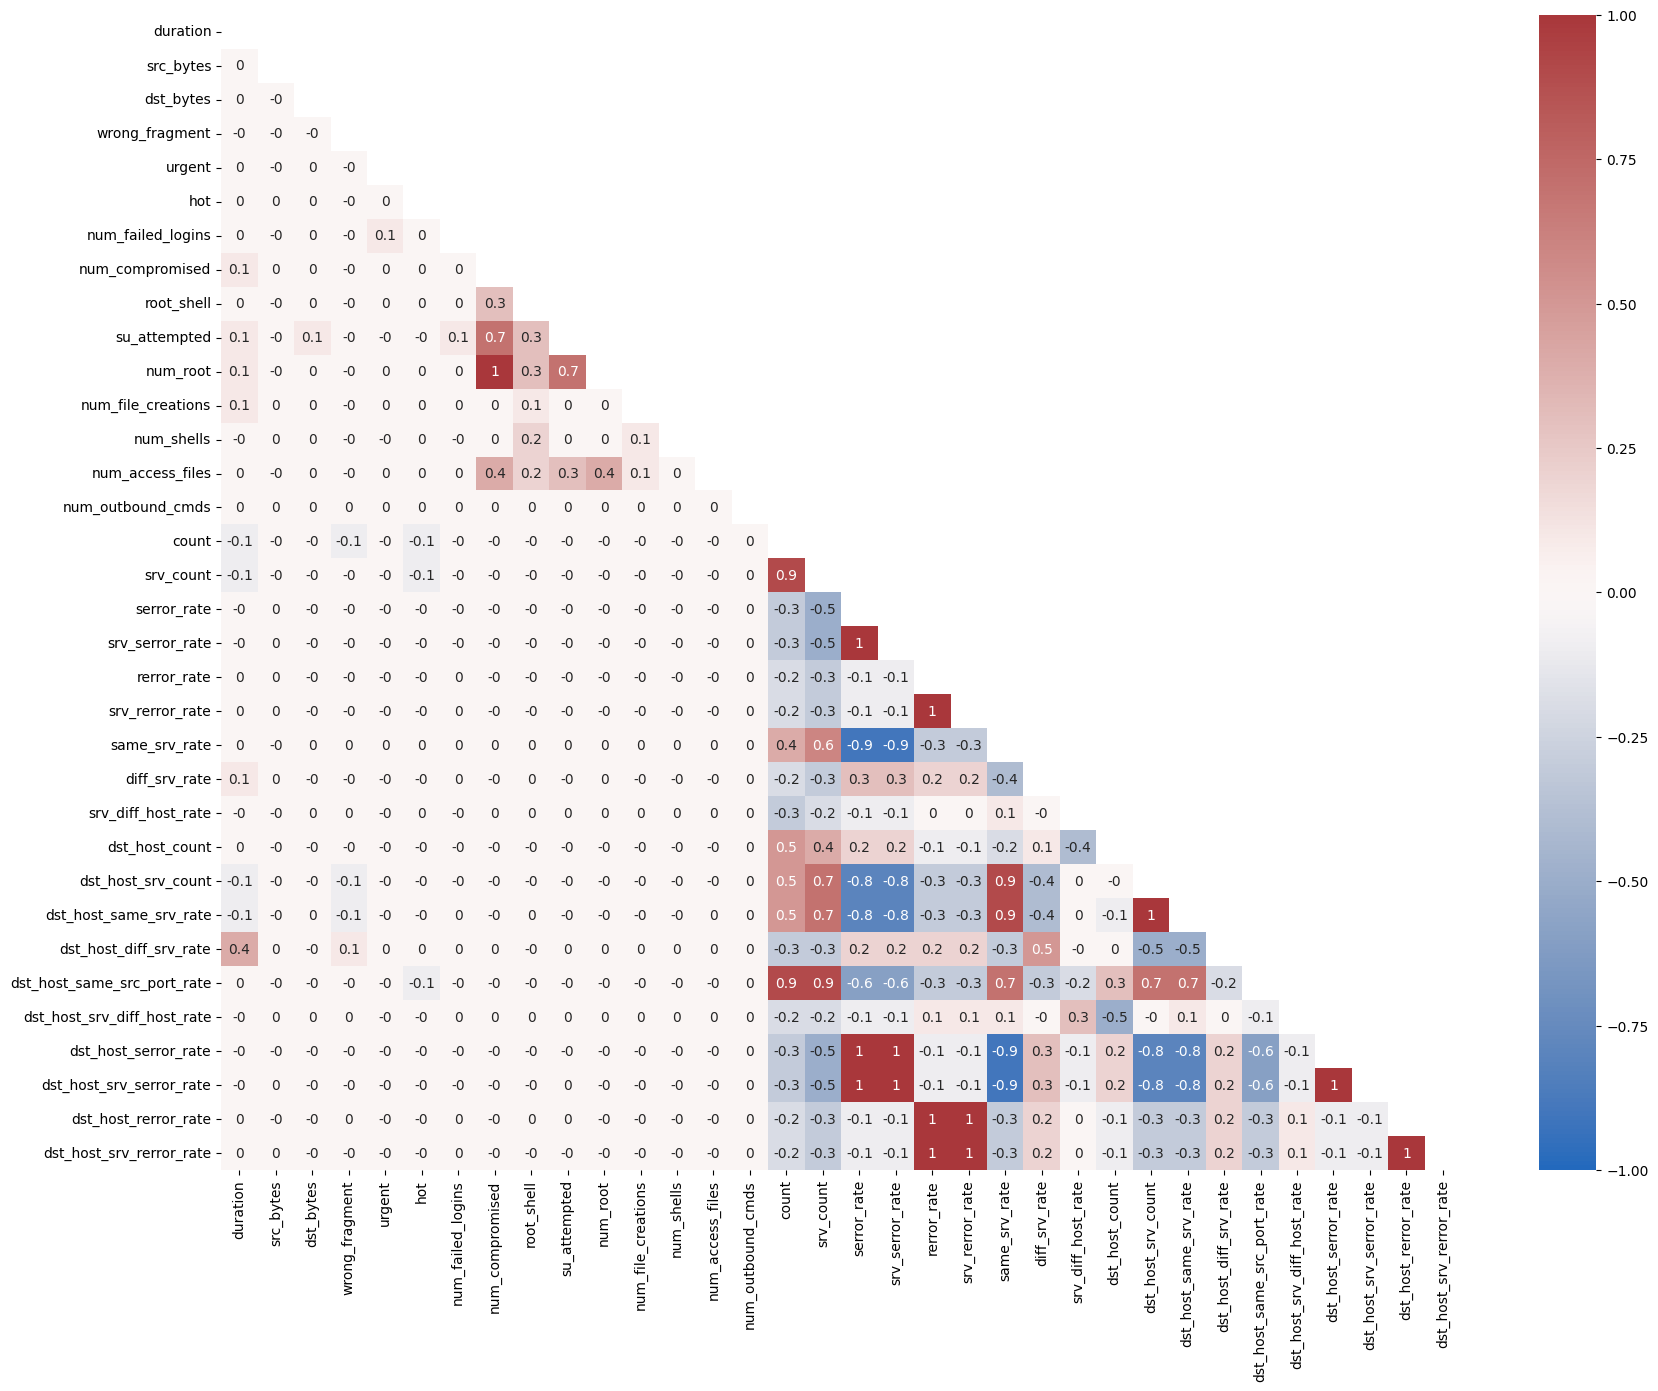

In [ ]:
mask = np.triu(np.ones_like(corr_df))
plt.figure(figsize=(20, 15))
sns.heatmap(corr_df, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag',mask=mask)
plt.show()

In [ ]:
# Finding features with correlation value more than specified threshold value (bar=0.9)
# Correlation matrix
corr_df_abs = corr_df.abs()

# Select upper triangle of correlation matrix
upper = corr_df_abs.where(np.triu(np.ones(corr_df_abs.shape), k=1).astype(bool))

# Find features with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]
to_drop
# Drop features
# df.drop(to_drop, axis=1, inplace=True)

['num_root',
 'srv_count',
 'srv_serror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate']

### Analysis report

* Find the ratio of attacked transactions vs normal transactions

    Hint: encode instrusion_type column by replacing normal with 1 and all other with 0

* Describe the statistics of attacked and normal transactions
    
    Hint: Min, Max, Mean
    
* Select any two features that influence the intrusion_type and visualize the scatter plot to see the separation of normal and attacked

In [ ]:
# Add another col binary_label
data_df = data_df.withColumn("binary_label", when(data_df["intrusion_type"] == "normal.", 1).otherwise(0))
# data_df.printSchema()

In [ ]:
att_transactions = data_df.select("*").where(column("binary_label") == 0).count()
normal_transactions = data_df.select("*").where(column("binary_label") == 1).count()
att_transactions, normal_transactions, att_transactions/normal_transactions

(396743, 97278, 4.0784452805361955)

In [ ]:
att_df = data_df.select("binary_label").where(column("binary_label") == 0)
nor_df = data_df.select("binary_label").where(column("binary_label") == 1)

att_df.describe().show()
nor_df.describe().show()


+-------+------------+
|summary|binary_label|
+-------+------------+
|  count|      396743|
|   mean|         0.0|
| stddev|         0.0|
|    min|           0|
|    max|           0|
+-------+------------+

+-------+------------+
|summary|binary_label|
+-------+------------+
|  count|       97278|
|   mean|         1.0|
| stddev|         0.0|
|    min|           1|
|    max|           1|
+-------+------------+



In [ ]:
data_df.show(10)
pd_df = data_df.toPandas()


+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+--------------+------------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_di

<Figure size 3000x1500 with 0 Axes>

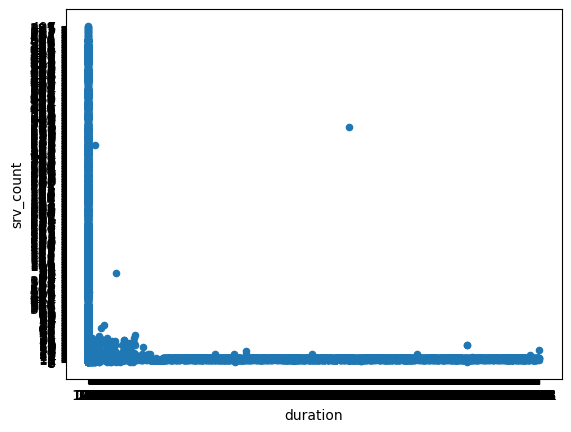

In [ ]:
plt.figure(figsize=(30, 15))
pd_df.plot.scatter(x='duration', y='srv_count')
plt.show()